In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train_data = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
print(f"train_data.shape: {train_data.shape}")
print(f"test_data.shape: {test_data.shape}")

train_data.shape: (8693, 14)
test_data.shape: (4277, 13)


In [4]:
train_data.describe()
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


<Axes: xlabel='Transported'>

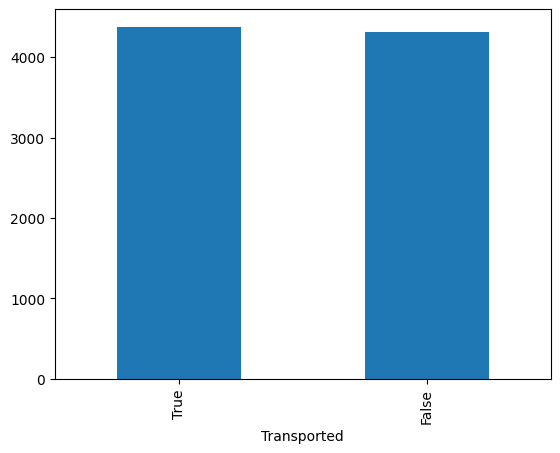

In [5]:
# 分析DataFrame中Transported的值出现的次数
# value_counts用来统计Transported列中每个唯一值出现的次数
plot_train = train_data.Transported.value_counts()
# 借助上面的内容绘制条状图
plot_train.plot(kind='bar')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

29813.0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

<Axes: xlabel='VRDeck', ylabel='Count'>

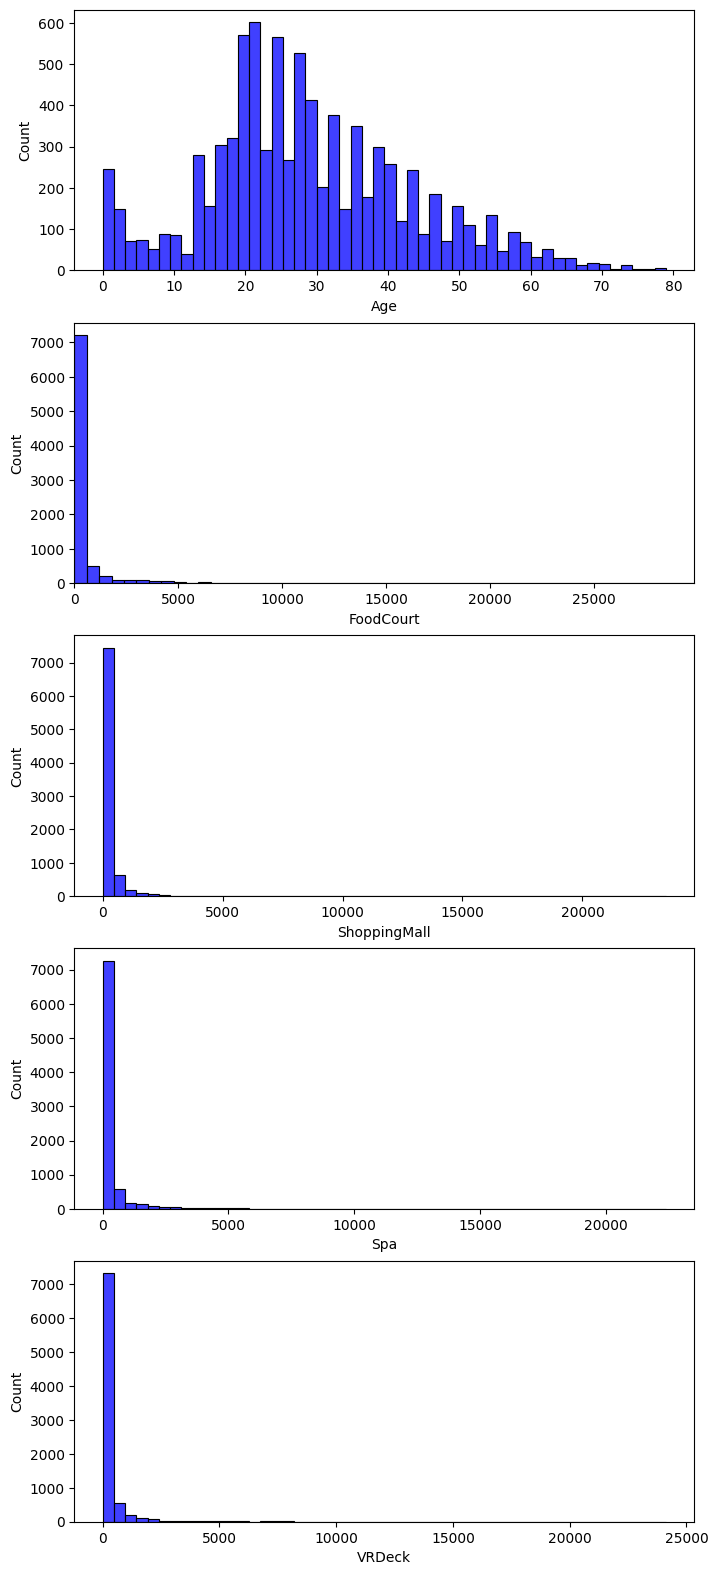

In [6]:
fig, ax = plt.subplots(5, 1, figsize=(8, 8))
plt.subplots_adjust(top=2)

sns.histplot(train_data['Age'], color='b', bins=50, ax=ax[0])

max_foodcourt = train_data['FoodCourt'].max()
print(max_foodcourt)
sns.histplot(train_data['FoodCourt'], color='b', bins=50, ax=ax[1])
ax[1].set_xlim(0, max_foodcourt)

sns.histplot(train_data['ShoppingMall'], color='b', bins=50, ax=ax[2])

sns.histplot(train_data['Spa'], color='b', bins=50, ax=ax[3])

sns.histplot(train_data['VRDeck'], color='b', bins=50, ax=ax[4])

In [7]:
# 预处理数据：唯一标识符，比如ID或者name或者邮箱这种信息可以去掉，因为对预测没有帮助
print(f"train_data.colunmns: {train_data.columns}\n\n")
train_data = train_data.drop(['PassengerId', 'Name'], axis=1)
print(f"train_data.colunmns: {train_data.columns}\n\n")
print(f"test_data.colunmns: {test_data.columns}")

train_data.colunmns: Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')


train_data.colunmns: Index(['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported'],
      dtype='object')


test_data.colunmns: Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name'],
      dtype='object')


In [8]:
# 把test的passenger ID保留下来，然后把它和name一起删掉
test_id = test_data['PassengerId']
print(test_id)
test_data = test_data.drop(['PassengerId', 'Name'], axis=1)
print(f"test_data.colunmns: {test_data.columns}")

0       0013_01
1       0018_01
2       0019_01
3       0021_01
4       0023_01
         ...   
4272    9266_02
4273    9269_01
4274    9271_01
4275    9273_01
4276    9277_01
Name: PassengerId, Length: 4277, dtype: object
test_data.colunmns: Index(['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'],
      dtype='object')


In [9]:
# 检查缺失值，并对缺失值的数量进行排序，缺失值最多的列排在最前面
missing_value = train_data.isnull().sum().sort_values(ascending=False)
print("Train missing value: \n{}".format(missing_value))

test_missing = test_data.isnull().sum().sort_values(ascending=False)
print("Test missing value: \n{}".format(test_missing))

Train missing value: 
CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
Transported       0
dtype: int64
Test missing value: 
FoodCourt       106
Spa             101
Cabin           100
ShoppingMall     98
CryoSleep        93
VIP              93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
dtype: int64


In [10]:
# 处理这些缺失值
mode_train = train_data.mode().iloc[0]
train_data = train_data.fillna(mode_train)
print(mode_train)
mode_test = test_data.mode().iloc[0]
test_data = test_data.fillna(mode_test)
print(mode_test)

HomePlanet            Earth
CryoSleep             False
Cabin               G/734/S
Destination     TRAPPIST-1e
Age                    24.0
VIP                   False
RoomService             0.0
FoodCourt               0.0
ShoppingMall            0.0
Spa                     0.0
VRDeck                  0.0
Transported            True
Name: 0, dtype: object
HomePlanet            Earth
CryoSleep             False
Cabin               G/160/P
Destination     TRAPPIST-1e
Age                    18.0
VIP                   False
RoomService             0.0
FoodCourt               0.0
ShoppingMall            0.0
Spa                     0.0
VRDeck                  0.0
Name: 0, dtype: object


In [11]:
# 检查缺失值，并对缺失值的数量进行排序，缺失值最多的列排在最前面
missing_value = train_data.isnull().sum().sort_values(ascending=False)
print("Train missing value: \n{}".format(missing_value))

test_missing = test_data.isnull().sum().sort_values(ascending=False)
print("Test missing value: \n{}".format(test_missing))

Train missing value: 
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64
Test missing value: 
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64


In [12]:
# 数据预处理到此结束
print(f"train_data.shape: {train_data.shape}")
print(f"test_data.shape: {test_data.shape}")
print(train_data.columns, end='\n')
print(test_data.columns, end='\n')
print(set(train_data.columns) - set(test_data.columns))

train_data.shape: (8693, 12)
test_data.shape: (4277, 11)
Index(['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported'],
      dtype='object')
Index(['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'],
      dtype='object')
{'Transported'}


In [13]:
print(torch.cuda.is_available())

True


In [14]:
train_labels = torch.tensor(train_data.Transported.values.reshape(-1, 1), dtype=torch.bool)
print("train_labels.shape: {}".format(train_labels.shape))
print(train_labels[:5])

train_labels.shape: torch.Size([8693, 1])
tensor([[False],
        [ True],
        [False],
        [False],
        [ True]])


In [15]:
# 统一转独热编码然后再转tensor，分开转会出问题
all_features = pd.concat((train_data.drop(['Transported'], axis=1),test_data))
all_features = pd.get_dummies(all_features)
print("all_features.shape: {}".format(all_features.shape))
n_train = train_data.shape[0]
all_features = all_features.astype(float)
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
print("train_features.shape: {}".format(train_features.shape))
print("test_features.shape: {}".format(test_features.shape))
print(train_features)

all_features.shape: (12970, 9839)
train_features.shape: torch.Size([8693, 9839])
test_features.shape: torch.Size([4277, 9839])
tensor([[ 0., 39.,  0.,  ...,  0.,  0.,  1.],
        [ 0., 24.,  0.,  ...,  0.,  0.,  1.],
        [ 0., 58.,  1.,  ...,  0.,  0.,  1.],
        ...,
        [ 0., 26.,  0.,  ...,  0.,  0.,  1.],
        [ 0., 32.,  0.,  ...,  1.,  0.,  0.],
        [ 0., 44.,  0.,  ...,  0.,  0.,  1.]])


In [16]:
batch_size = 100
# 把训练集和结果集一一匹配成为一个元组
dataset = torch.utils.data.TensorDataset(train_features, train_labels)
print(dataset[:5])
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
for i, (data, labels) in enumerate(train_loader):
    if i == 3:
        break;
    print(i, data, labels)

(tensor([[ 0., 39.,  0.,  ...,  0.,  0.,  1.],
        [ 0., 24.,  0.,  ...,  0.,  0.,  1.],
        [ 0., 58.,  1.,  ...,  0.,  0.,  1.],
        [ 0., 33.,  0.,  ...,  0.,  0.,  1.],
        [ 0., 16.,  0.,  ...,  0.,  0.,  1.]]), tensor([[False],
        [ True],
        [False],
        [False],
        [ True]]))
0 tensor([[ 1., 20.,  0.,  ...,  0.,  1.,  0.],
        [ 1., 35.,  0.,  ...,  0.,  0.,  1.],
        [ 1., 46.,  0.,  ...,  0.,  0.,  1.],
        ...,
        [ 0., 54.,  0.,  ...,  0.,  0.,  1.],
        [ 1., 17.,  0.,  ...,  0.,  1.,  0.],
        [ 0., 39.,  0.,  ...,  0.,  0.,  1.]]) tensor([[ True],
        [ True],
        [False],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [False],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False

In [17]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, n_features):
        super(LogisticRegressionModel, self).__init__()
        self.linear1 = nn.Linear(n_features, 200)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(200, 100)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(100, 1)
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.linear3(x)
        x = torch.sigmoid(x)
        return x

In [18]:
# 输入应该是特征的个数 - 也就是列数
n_features = train_features.shape[1]
model = LogisticRegressionModel(n_features).to("cuda")
print(model)

LogisticRegressionModel(
  (linear1): Linear(in_features=9839, out_features=200, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=200, out_features=100, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=100, out_features=1, bias=True)
)


In [19]:
loss = nn.MSELoss()
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# 学习率衰减，使用StepLR衰减
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


epoch: 0, loss_sum: 14.989840753376484
epoch: 10, loss_sum: 8.182171009480953
epoch: 20, loss_sum: 7.840380776673555
epoch: 30, loss_sum: 7.357344515621662
epoch: 40, loss_sum: 7.258704036474228
epoch: 50, loss_sum: 7.151556082069874
epoch: 60, loss_sum: 6.975591741502285
epoch: 70, loss_sum: 6.95162894949317
epoch: 80, loss_sum: 6.930085692554712
epoch: 90, loss_sum: 6.9022392854094505


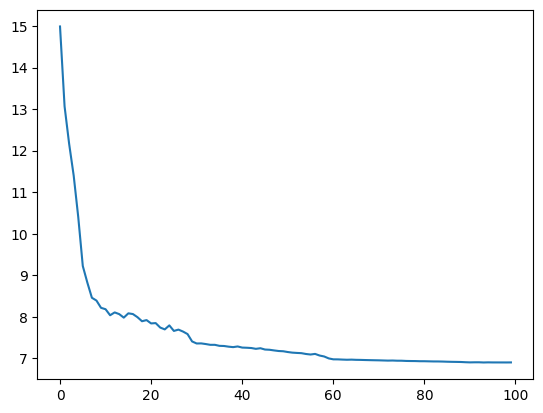

In [20]:
epochs = 100
def train(train_loader):
    train_loss = []
    for epoch in range(epochs):
        # 每个epoch开始时进行学习率衰减
        scheduler.step()
        loss_sum = 0
        for train_batch, labels in train_loader:
            train_batch, labels = train_batch.to("cuda"), labels.to("cuda").float()
            
            # 计算训练值和真实值的差距得到损失
            l = loss(model(train_batch), labels)
            
            # 清除pytorch中的累积梯度
            optimizer.zero_grad()
            
            # 反向传播
            l.backward()
            
            # 更新参数
            optimizer.step()
            
            # 累加损失
            loss_sum += l.item()
        if(epoch % 10 == 0):
            print("epoch: {}, loss_sum: {}".format(epoch, loss_sum))
        train_loss.append(loss_sum)
        
    plt.plot(range(epochs), train_loss)
    plt.show()
train(train_loader)

In [21]:
def test(test_feature):
    test_features = test_feature.to("cuda")
    with torch.no_grad():
        preds = model(test_features)
    preds_bool = preds >= 0.5
    return preds_bool.cpu().numpy()
pred_label = test(test_features)
print(pred_label)

PassengerId = test_id
Transported = pred_label.squeeze()
submission = pd.DataFrame({
    "PassengerId": PassengerId,
    "Transported": Transported
})
print(submission)

[[False]
 [False]
 [ True]
 ...
 [ True]
 [ True]
 [ True]]
     PassengerId  Transported
0        0013_01        False
1        0018_01        False
2        0019_01         True
3        0021_01         True
4        0023_01         True
...          ...          ...
4272     9266_02         True
4273     9269_01        False
4274     9271_01         True
4275     9273_01         True
4276     9277_01         True

[4277 rows x 2 columns]


In [22]:
submission.to_csv("submission.csv", index=False)